# Core Visualization for Presentation

This notebook generates key visualizations for presentation based on analysis results documented in README.md

## 1. Import Libraries and Data Preparation

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import platform
sns.set_style('whitegrid')

In [7]:
# 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # other OS
    # Nanum font needs to be installed
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

In [ ]:
# Load and preprocess data
print('Loading and preprocessing data...')
sales_df = pd.read_csv('data/processed_data.csv', encoding='utf-8-sig')
people_df = pd.read_csv('data/population/생활인구_전처리완료.csv', encoding='utf-8-sig')

sales_df['ADSTRD_CD'] = sales_df['ADSTRD_CD'].astype(str)
people_df['행정동코드'] = people_df['행정동코드'].astype(str)
people_df_renamed = people_df.rename(columns={
    '행정동코드': 'ADSTRD_CD', '연도': 'YEAR', '분기': 'QUARTER'
})

sales_agg = sales_df.groupby(['ADSTRD_CD', 'ADSTRD_NM', 'YEAR', 'QUARTER']).agg({
    'THSMON_SELNG_AMT': 'sum',
    'ECNMY_ACTIVE_POP_SELNG_AMT': 'sum'
}).reset_index()

pop_cols = ['ADSTRD_CD', 'YEAR', 'QUARTER', '총생활인구_평균', '경제활동인구_평균'] + [col for col in people_df_renamed.columns if 'TMZON' in col]
merged_df = sales_agg.merge(people_df_renamed[pop_cols], on=['ADSTRD_CD', 'YEAR', 'QUARTER'], how='inner')

merged_df['1인당_평균매출'] = merged_df['THSMON_SELNG_AMT'] / merged_df['총생활인구_평균']

print('Data preparation complete')

## 2. Correlation Analysis: Population vs Sales

/var/folders/rv/2m7fs5ls63jgc4gpfkbwd6lm0000gn/T/ipykernel_56171/4045329849.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{x/1e10:.0f}' for x in axes[0].get_yticks()])
/var/folders/rv/2m7fs5ls63jgc4gpfkbwd6lm0000gn/T/ipykernel_56171/4045329849.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels([f'{x/1e10:.0f}' for x in axes[1].get_yticks()])


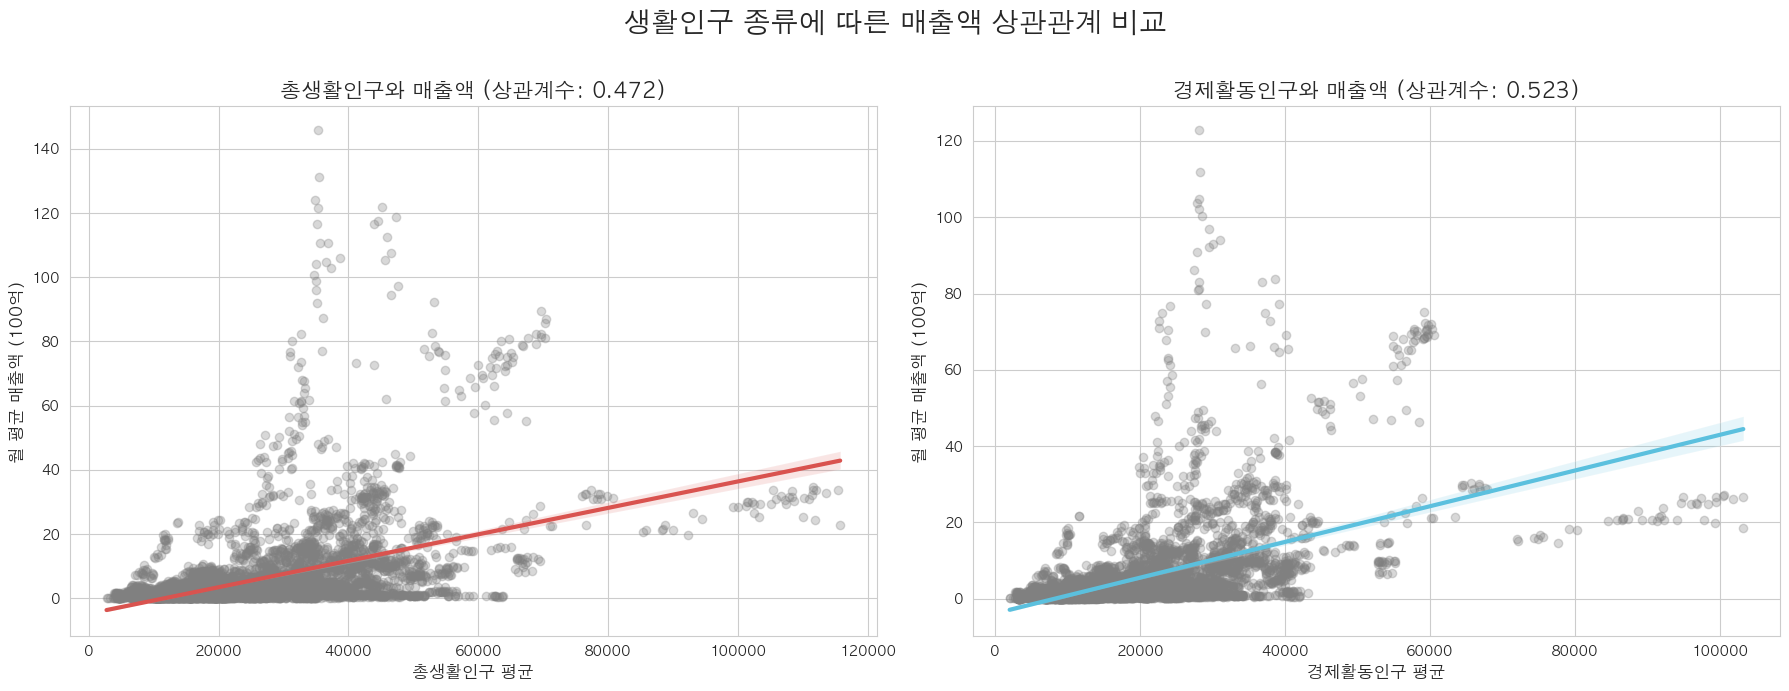

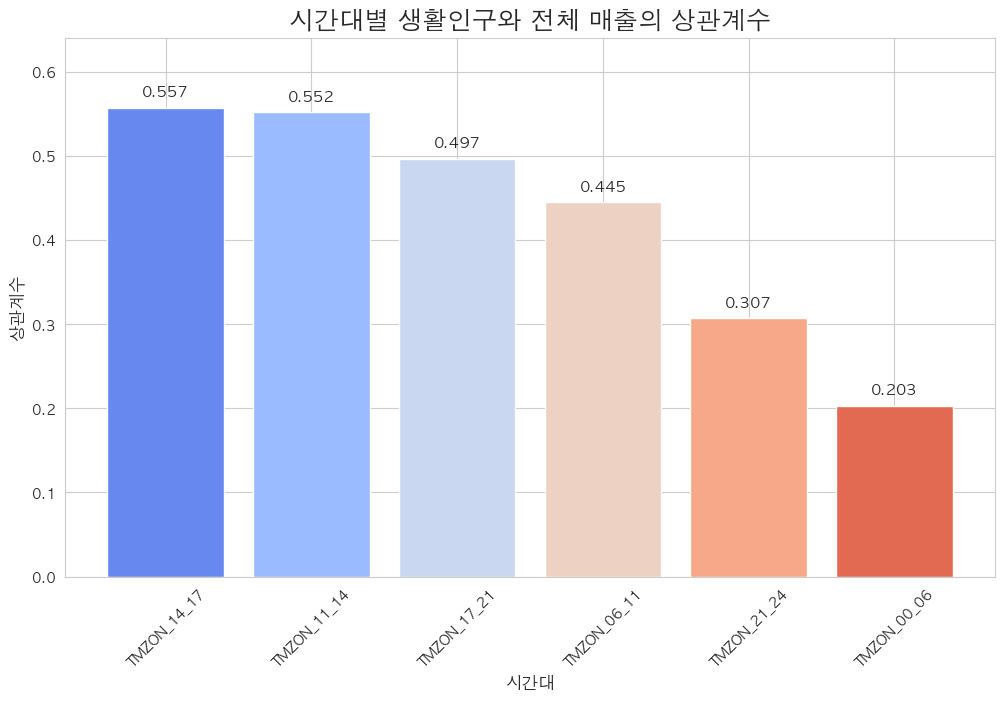

In [9]:
# 2-1. 총생활인구 vs 경제활동인구와 매출액 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('생활인구 종류에 따른 매출액 상관관계 비교', fontsize=20, fontweight='bold')

# 총생활인구 vs 총매출액
sns.regplot(data=merged_df, x='총생활인구_평균', y='THSMON_SELNG_AMT', ax=axes[0], 
            scatter_kws={'alpha':0.3, 'color': 'gray'}, line_kws={'color':'#d9534f', 'linewidth': 3})
corr1 = merged_df['총생활인구_평균'].corr(merged_df['THSMON_SELNG_AMT'])
axes[0].set_title(f'총생활인구와 매출액 (상관계수: {corr1:.3f})', fontsize=15)
axes[0].set_xlabel('총생활인구 평균', fontsize=12)
axes[0].set_ylabel('월 평균 매출액 (100억)', fontsize=12)
axes[0].set_yticklabels([f'{x/1e10:.0f}' for x in axes[0].get_yticks()])

# 경제활동인구 vs 경제활동인구 매출액
sns.regplot(data=merged_df, x='경제활동인구_평균', y='ECNMY_ACTIVE_POP_SELNG_AMT', ax=axes[1],
            scatter_kws={'alpha':0.3, 'color': 'gray'}, line_kws={'color':'#5bc0de', 'linewidth': 3})
corr2 = merged_df['경제활동인구_평균'].corr(merged_df['ECNMY_ACTIVE_POP_SELNG_AMT'])
axes[1].set_title(f'경제활동인구와 매출액 (상관계수: {corr2:.3f})', fontsize=15)
axes[1].set_xlabel('경제활동인구 평균', fontsize=12)
axes[1].set_ylabel('월 평균 매출액 (100억)', fontsize=12)
axes[1].set_yticklabels([f'{x/1e10:.0f}' for x in axes[1].get_yticks()])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2-2. 시간대별 생활인구와 매출의 상관계수
time_cols = [col for col in merged_df.columns if '생활인구_TMZON' in col]
time_corrs = {col.replace('생활인구_','').replace('_평균',''): merged_df[col].corr(merged_df['THSMON_SELNG_AMT']) for col in time_cols}
time_corrs_sorted = sorted(time_corrs.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 7))
keys = [item[0] for item in time_corrs_sorted]
values = [item[1] for item in time_corrs_sorted]
colors = sns.color_palette('coolwarm', len(values))

bars = plt.bar(keys, values, color=colors)
plt.title('시간대별 생활인구와 전체 매출의 상관계수', fontsize=18, fontweight='bold')
plt.xlabel('시간대', fontsize=12)
plt.ylabel('상관계수', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, max(values) * 1.15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=11)

plt.show()

## 3. Time Series Analysis: Sales and Population Trends (2020-2024)

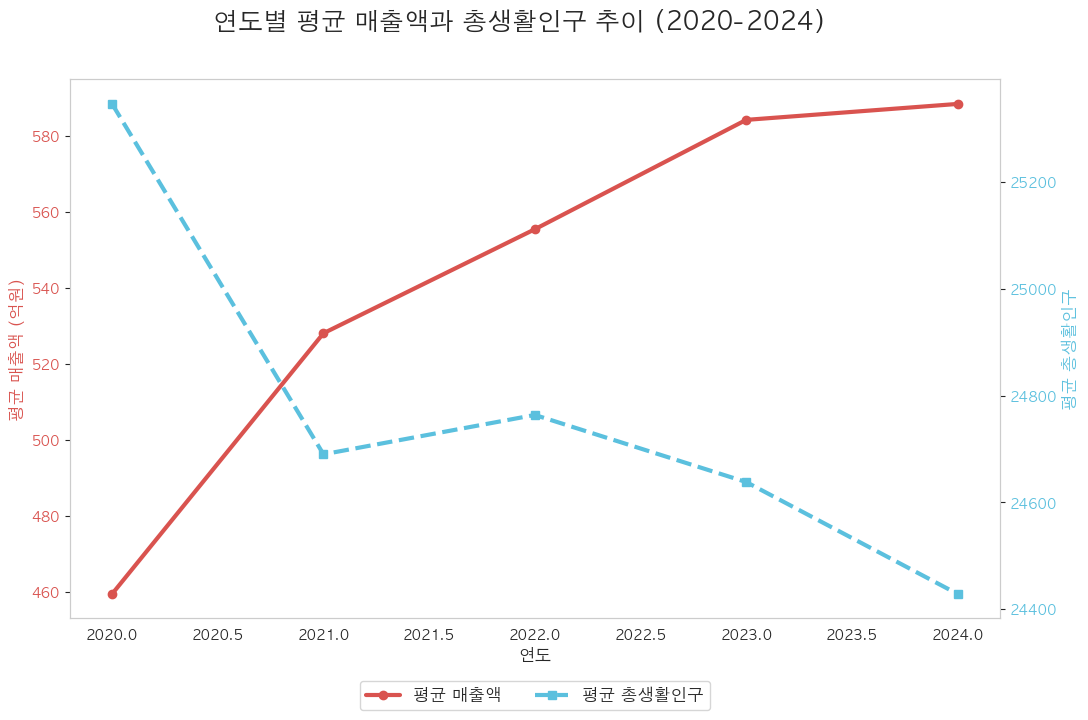

In [10]:
yearly_summary = merged_df.groupby('YEAR').agg({
    'THSMON_SELNG_AMT': 'mean',
    '총생활인구_평균': 'mean'
})

fig, ax1 = plt.subplots(figsize=(12, 7))
fig.suptitle('연도별 평균 매출액과 총생활인구 추이 (2020-2024)', fontsize=18, fontweight='bold')

# 첫 번째 Y축 (매출액)
color1 = '#d9534f'
ax1.set_xlabel('연도', fontsize=12)
ax1.set_ylabel('평균 매출액 (억원)', color=color1, fontsize=12)
ax1.plot(yearly_summary.index, yearly_summary['THSMON_SELNG_AMT'] / 1e8, color=color1, marker='o', linestyle='-', linewidth=3, label='평균 매출액')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(False)

# 두 번째 Y축 (생활인구)
ax2 = ax1.twinx()
color2 = '#5bc0de'
ax2.set_ylabel('평균 총생활인구', color=color2, fontsize=12)
ax2.plot(yearly_summary.index, yearly_summary['총생활인구_평균'], color=color2, marker='s', linestyle='--', linewidth=3, label='평균 총생활인구')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(False)

# 범례 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)

plt.show()

## 4. Sales Efficiency Analysis: Per Capita Sales

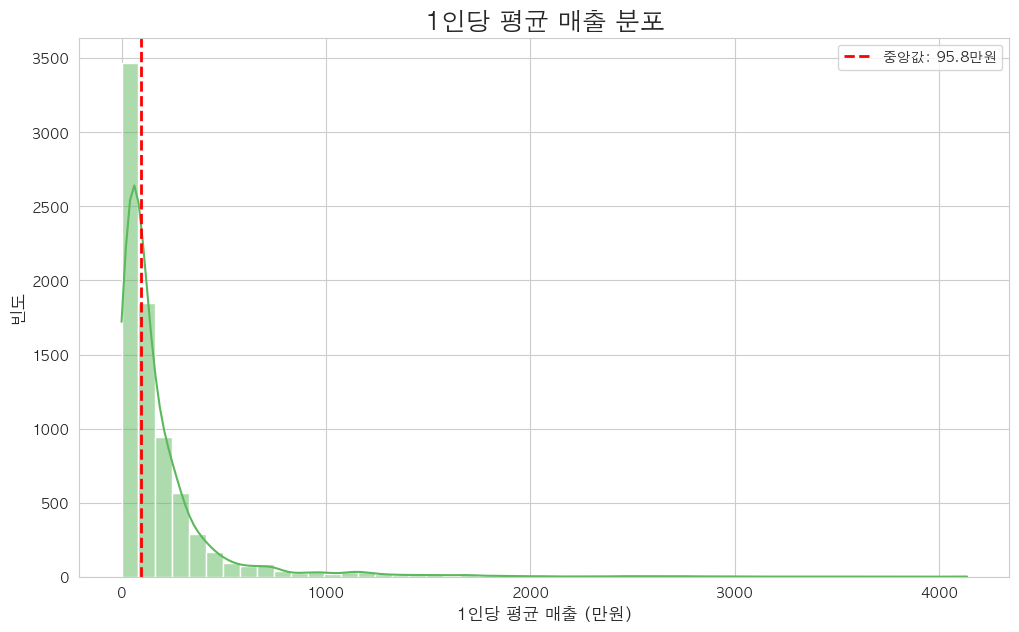

In [11]:
plt.figure(figsize=(12, 7))
sns.histplot(merged_df['1인당_평균매출'] / 10000, kde=True, bins=50, color='#5cb85c')

median_val = (merged_df['1인당_평균매출'] / 10000).median()
plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'중앙값: {median_val:.1f}만원')

plt.title('1인당 평균 매출 분포', fontsize=18, fontweight='bold')
plt.xlabel('1인당 평균 매출 (만원)', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.legend()
plt.show()